In [5]:
#%% LOAD PACKAGES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
# from os import path
from pathlib import Path
from datetime import datetime, timedelta
from scipy.optimize import least_squares
import calendar
import sklearn
from sklearn.linear_model import LinearRegression
from scipy.stats import gaussian_kde
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

In [6]:
work_dir=Path("/home/fransjevanoors/global_sr_module")

In [13]:
fol_out=f'{work_dir}/output/'

# define variables of interest
var=['p_mean','ep_mean','q_mean','t_mean','ai','si_p','si_ep','phi','tc','ntc','nonveg']
cc = pd.read_csv(f'{fol_out}/catchment_characteristics.csv',index_col=0)

In [12]:
cc

,p_mean,ep_mean,q_mean,t_mean,ai,si_p,si_ep,phi,tc,ntc,nonveg
br_0000495,5.985058,3.635537,3.210340,27.176950,1.646265,0.610597,0.051158,6,40.389229,47.804183,11.806588
fr_0000326,3.540341,2.105863,1.701488,10.755472,1.681183,0.365350,0.303236,6,28.631765,56.481887,14.886349
us_0002247,4.276623,2.636243,3.913700,16.772313,1.622242,0.179611,0.364593,6,39.580416,49.295330,11.124253


In [25]:
out_dir = f'{work_dir}/output/sr_calculation/'
sr = pd.read_csv(f'{out_dir}/sr_all_catchments.csv',index_col=0)
sr = sr.rename(columns={'2':'sr_2', '3':'sr_3', '5':'sr_5', '10':'sr_10', '20':'sr_20', '30':'sr_30', '40':'sr_40', '50':'sr_50', '60':'sr_60'})

In [26]:
sr

,sr_2,sr_3,sr_5,sr_10,sr_20,sr_30,sr_40,sr_50,sr_60
catch_id,,,,,,,,,
br_0000495,90.115378,90.115378,90.115378,90.115378,90.115378,90.115378,90.115378,90.115378,90.115378
fr_0000326,46.406726,46.406726,46.406726,46.406726,46.406726,46.406726,46.406726,46.406726,46.406726


In [42]:
dpar = ['p_mean','ep_mean','t_mean','si_p','phi']
cc_sr = pd.concat([cc,sr],axis=1)

In [43]:
df = cc_sr

In [44]:
df

,p_mean,ep_mean,q_mean,t_mean,ai,si_p,si_ep,phi,tc,ntc,nonveg,sr_2,sr_3,sr_5,sr_10,sr_20,sr_30,sr_40,sr_50,sr_60
br_0000495,5.985058,3.635537,3.210340,27.176950,1.646265,0.610597,0.051158,6,40.389229,47.804183,11.806588,90.115378,90.115378,90.115378,90.115378,90.115378,90.115378,90.115378,90.115378,90.115378
fr_0000326,3.540341,2.105863,1.701488,10.755472,1.681183,0.365350,0.303236,6,28.631765,56.481887,14.886349,46.406726,46.406726,46.406726,46.406726,46.406726,46.406726,46.406726,46.406726,46.406726
us_0002247,4.276623,2.636243,3.913700,16.772313,1.622242,0.179611,0.364593,6,39.580416,49.295330,11.124253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
df.columns

Index(['p_mean', 'ep_mean', 'q_mean', 't_mean', 'ai', 'si_p', 'si_ep', 'phi',
       'tc', 'ntc', 'nonveg', 'sr_2', 'sr_3', 'sr_5', 'sr_10', 'sr_20',
       'sr_30', 'sr_40', 'sr_50', 'sr_60'],
      dtype='object')

In [48]:
sr_rp = ['sr_20']
col = dpar + sr_rp
# col = np.concatenate(dpar,sr_rp)
df = df[col]

# exclude nan catchments
df = df.dropna()

# exclude sr=zero catchments
df = df[df[sr_rp]>0]

# standardize
df_st = pd.DataFrame(index=df.index, columns=[col])
df_st = (df - df.mean())/df.std()

In [110]:
dpar = ['p_mean','ep_mean','t_mean','si_p']
rp = 20
cc_df = pd.read_csv(f'{work_dir}/output/catchment_characteristics.csv',index_col=0)
sr_df = pd.read_csv(f'{work_dir}/output/sr_calculation/sr_all_catchments.csv',index_col=0)
# get df and df_st for to be used in regression
df = regression_input(cc_df, sr_df, dpar, rp)[0]
df_st = regression_input(cc_df, sr_df, dpar, rp)[1]


In [111]:
df_st

,p_mean,ep_mean,t_mean,si_p,sr_20
br_0000495,0.707107,0.707107,0.707107,0.707107,0.707107
fr_0000326,-0.707107,-0.707107,-0.707107,-0.707107,-0.707107


,p_mean,ep_mean,t_mean,si_p,r_sq,r_sq_adj,aic,pval,nobs
0,0.25,0.25,0.25,0.25,1.0,1.0,-134.142,NaN,2.0


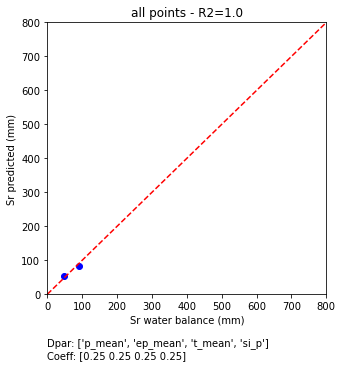

In [155]:
# regression
cc_df = pd.read_csv(f'{work_dir}/output/catchment_characteristics.csv',index_col=0)
sr_df = pd.read_csv(f'{work_dir}/output/sr_calculation/sr_all_catchments.csv',index_col=0)
dpar = ['p_mean','ep_mean','t_mean','si_p']
rp = 20
run_regression(cc_df, sr_df, dpar, rp)

In [167]:
def regression_plot(sr,sr_pred,dpar,par,r_sq, tc_th, ntc_th, nonveg_th):    
    # Calculate the point density -> this only works if we have more points
    # xy = np.vstack([sr,sr_pred])
    # z = gaussian_kde(xy)(xy)
    x,y = sr, sr_pred
    #plot
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    ax.plot(x,y,'bo')
    # ax.scatter(x, y, c=z)
    ax.plot([0,1200],[0,1200],'r--')
    ax.set_xlabel('Sr water balance (mm)')
    ax.set_ylabel('Sr predicted (mm)')
    ax.set_xlim(0,800)
    ax.set_ylim(0,800)
    ax.text(0,-150,'Dpar: '+str(dpar))
    ax.text(0,-190,'Coeff: '+str(np.round(par.values,3)))
    ax.set_title(f'veg thresholds: tc:{tc_th}, ntc:{ntc_th}, nonveg:{nonveg_th},  R2={np.round(r_sq,3)}')

In [168]:
def regression(df, df_st, dpar, rp):
    sr_rp = f'sr_{rp}' 
    x,sr = df_st[dpar],df_st[sr_rp]
    model = sm.OLS(sr,x)
    results = model.fit()
    par = np.round(results.params,3)
    pred_st = model.predict(par)
    r_sq = np.round(results.rsquared,3)
    r_sq_adj = np.round(results.rsquared_adj,3)
    aic = np.round(results.aic,3)
    pval = np.round(results.pvalues,3)
    nobs = results.nobs

    pred = pred_st * np.std(df[sr_rp]) + np.mean(df[sr_rp])
    x = df[sr_rp]
    y = pred
    
    return x,y,par,r_sq,r_sq_adj,aic,pval,nobs

In [169]:
def regression_input(cc_df, sr_df, dpar, rp, tc_th, ntc_th, nonveg_th):
    # rename sr columns
    sr_df = sr_df.rename(columns={'2':'sr_2', '3':'sr_3', '5':'sr_5', '10':'sr_10', '20':'sr_20', '30':'sr_30', '40':'sr_40', '50':'sr_50', '60':'sr_60'})
    
    # concat catchment characteristics with sr dataframe
    df = pd.concat([cc_df,sr_df],axis=1)

    # define columns for regression (dpar and sr column)
    sr_rp = f'sr_{rp}'
    col = dpar + [sr_rp]
    df = df[col]
    
    # treecover
    df_tc = cc_df[['tc', 'ntc', 'nonveg']]

    # select catchments based on treecover threshold
    df = df[df_tc['tc']>tc_th]
    df = df[df_tc['ntc']>ntc_th]
    df = df[df_tc['nonveg']>nonveg_th]

    # exclude nan catchments
    df = df.dropna()

    # exclude sr=zero catchments
    df = df[df[sr_rp]>0]

    # standardize values
    df_st = pd.DataFrame(index=df.index, columns=[col])
    df_st = (df - df.mean())/df.std()
    
    return df, df_st
    
    

In [170]:
def regression_table(dpar,par,r_sq,r_sq_adj,aic,pval,nobs, tc_th, ntc_th, nonveg_th):
    df = pd.DataFrame(index=[0], columns=[dpar])
    df[dpar] = par
    df['tc_th']=tc_th
    df['ntc_th']=ntc_th
    df['nonveg_th']=nonveg_th
    df['r_sq'] = r_sq
    df['r_sq_adj'] = r_sq_adj
    df['aic'] = aic
    df['pval'] = pval
    df['nobs'] = nobs
    return df

In [171]:
def run_regression(cc_df, sr_df, dpar, rp, tc_th, ntc_th, nonveg_th):
    # prepare input
    df = regression_input(cc_df, sr_df, dpar, rp, tc_th, ntc_th, nonveg_th)[0]
    df_st = regression_input(cc_df, sr_df, dpar, rp, tc_th, ntc_th, nonveg_th)[1]
    
    # regression
    rp = 20
    r = regression(df, df_st, dpar, rp)
    sr, sr_pred = r[0], r[1]
    par,r_sq,r_sq_adj,aic,pval,nobs = r[2],r[3],r[4],r[5],r[6],r[7]
    
    # plot results
    regression_plot(sr,sr_pred,dpar,par,r_sq, tc_th, ntc_th, nonveg_th)
    
    # make table
    df = regression_table(dpar,par,r_sq,r_sq_adj,aic,pval,nobs, tc_th, ntc_th, nonveg_th)
    
    return df

,p_mean,ep_mean,t_mean,si_p,tc_th,ntc_th,nonveg_th,r_sq,r_sq_adj,aic,pval,nobs
0,0.25,0.25,0.25,0.25,10,0,0,1.0,1.0,-134.142,NaN,2.0


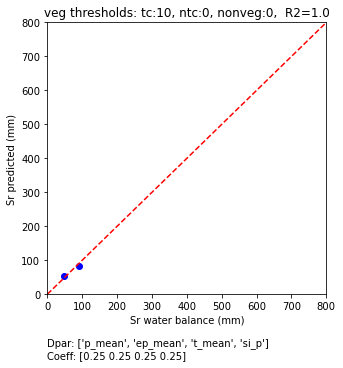

In [173]:
cc_df = pd.read_csv(f'{work_dir}/output/catchment_characteristics.csv',index_col=0)
sr_df = pd.read_csv(f'{work_dir}/output/sr_calculation/sr_all_catchments.csv',index_col=0)
dpar = ['p_mean','ep_mean','t_mean','si_p']
rp = 20
tc_th=10
ntc_th=0
nonveg_th=0
run_regression(cc_df, sr_df, dpar, rp, tc_th, ntc_th, nonveg_th)